In [1]:
from sklearn.cross_decomposition import CCA

import os, sys
from glob import glob
from utils import p2r, stack_features, word2sense, regression, cv_regression_w2s, image_to_tensor, Subject, listdir, correlation
import numpy as np
from tqdm import tqdm

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from collections import OrderedDict 
import string
from sklearn.model_selection import KFold


In [11]:
# Setup w2s
w2s_file = "ThingsWrd2Sns.txt"
_, w2s_embeddings = word2sense(w2s_file)
nDim = 2250
w2s = np.zeros((1470, 2250))


# Setup features
condition_features = np.load('features_all_unflattened.npy', allow_pickle=True)

nfeat = 0
for l in condition_features.item().get('aardvark'):
    if l.shape[0] == 4096:
        continue
    nfeat = nfeat + l.shape[0]
    print(l.shape)
print(nfeat)
features = np.zeros((len(w2s_embeddings), nfeat))
idx = 0
for i, condition in enumerate(condition_features.item()):
    c_name = condition.split('/')[-1]
    if c_name in w2s_embeddings:
        feat = 0
        for l, layer in enumerate(condition_features.item().get(condition)):
            if layer.shape[0] == 4096:
                continue
            for filt in range(layer.shape[0]):
                features[idx, feat] = np.amax(np.array(layer[filt]))
                feat = feat + 1
        idx = idx + 1

# Setup voxels
voxels = np.zeros((1470, 200))
idx = 0
for i, c in enumerate(condition_features.item()):
    c_name = c.split('/')[-1]
    if c_name in w2s_embeddings:
        voxel = np.load('./predicted_EVC_conv5' + '/' + c_name + '/' + c_name + '.npy')
        #print(voxel.shape)
        voxels[idx, :] = voxel
        w2s[idx, :] = w2s_embeddings[c_name]
        idx = idx + 1

torch.Size([192, 15, 15])
torch.Size([384, 15, 15])
torch.Size([256, 15, 15])
torch.Size([256, 7, 7])
1088


In [12]:
# Cat's new word2vec (312 categories)
w2v = np.zeros((312, 300))

# Setup w2s
embedding_file = "ThingsWrd2Vec_subset.txt"
f = open(embedding_file, 'r', encoding='utf-8')
wordvec2lines = f.readlines()
f.close()

# Wordvec filtered by CM
wordvec2 = {}
for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word = (wordvec2lines[i].split(','))[0]
    if word in w2s_embeddings:
        wordvec2[word] = wordvec2lines[i].split(',')[1:]
        wordvec2[word][-1] = wordvec2[word][-1].replace('\n', '')

for wv in wordvec2:
    wordvec2[wv] = np.array(wordvec2[wv]).astype(np.float)

    
nfeat = 0
for l in condition_features.item().get('aardvark'):
    if l.shape[0] == 4096:
        continue
    nfeat = nfeat + l.shape[0]
    print(l.shape)
print(nfeat)

features_w2v = np.zeros((len(wordvec2), nfeat))
idx = 0
for i, condition in enumerate(condition_features.item()):
    c_name = condition.split('/')[-1]
    if c_name in wordvec2:
        feat = 0
        for l, layer in enumerate(condition_features.item().get(condition)):
            if layer.shape[0] == 4096:
                continue
            for filt in range(layer.shape[0]):
                features_w2v[idx, feat] = np.amax(np.array(layer[filt]))
                feat = feat + 1
        idx = idx + 1    

# Setup voxels
idx = 0
voxels_w2v = np.zeros((len(wordvec2), 200))

for i, c in enumerate(condition_features.item()):
    c_name = c.split('/')[-1]
    if c_name in wordvec2:
        voxel = np.load('./predicted_EVC_conv5' + '/' + c_name + '/' + c_name + '.npy')

        voxels_w2v[idx, :] = voxel
        w2v[idx, :] = wordvec2[c_name]
        idx = idx + 1
        
print(voxels.shape)
print(w2v.shape)

torch.Size([192, 15, 15])
torch.Size([384, 15, 15])
torch.Size([256, 15, 15])
torch.Size([256, 7, 7])
1088
(1470, 200)
(312, 300)


(210, 5)
[-0.33611413 -0.05413385 -0.01181923  0.1140636   0.02580966]
[-2.46924988e-07 -3.49060015e-08 -1.01058526e-08  8.59775421e-08
  2.27231785e-08]


Text(0, 0.5, 'Scores')

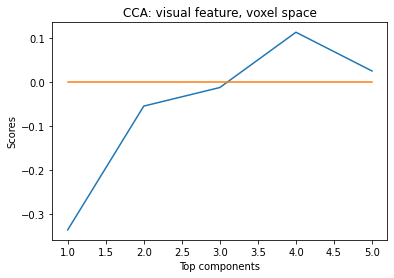

In [20]:
cca1 = CCA(n_components=5)
cca1.fit(features, voxels)
kf = KFold(n_splits = 7)
for train_index, test_index in kf.split(features):
    X_r = []
    Y_r = []
    features_train = features[train_index,]
    voxels_train = voxels[train_index,]
    features_test = features[test_index,]
    voxels_test = voxels[test_index,]
    
    X_train_r, Y_train_r = cca1.transform(features_train, voxels_train)
    X_test_r, Y_test_r = cca1.transform(features_test, voxels_test)

    X_r.append(X_test_r)    
    Y_r.append(Y_test_r)    
    
X_r = np.array(X_r)
Y_r = np.array(Y_r)
X_r = np.reshape(X_r, (X_r.shape[1], X_r.shape[2]))
Y_r = np.reshape(Y_r, (Y_r.shape[1], Y_r.shape[2]))
print(X_r.shape)

mean_X_r = np.nanmean(X_r, axis=0) # mean across k folds 
mean_Y_r = np.nanmean(Y_r, axis=0) # mean across k folds 

print(mean_X_r)
print(mean_Y_r)

plt.title('CCA: visual feature, voxel space')
x = np.arange(1, 6, 1)
plt.plot(x, mean_X_r)
plt.plot(x, mean_Y_r)
plt.xlabel('Top components')
plt.ylabel('Scores')


(210, 5)
[-0.00732969  0.01471224  0.00139813  0.00010782 -0.00653017]
[-0.02504007  0.0064063   0.00505333  0.00035737 -0.01999894]


Text(0, 0.5, 'Scores')

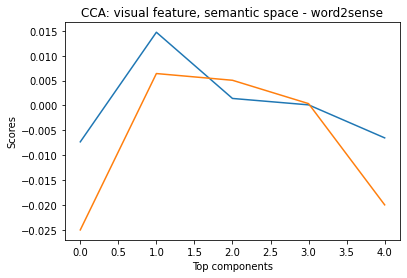

In [22]:
cca2 = CCA(n_components=5)
cca2.fit(features, w2s)
kf = KFold(n_splits = 7)
for train_index, test_index in kf.split(features):
    X_r = []
    Y_r = []
    features_train = features[train_index,]
    dims_train = w2s[train_index,]
    features_test = features[test_index,]
    dims_test = w2s[test_index,]
    
    X_train_r, Y_train_r = cca2.transform(features_train, dims_train)
    X_test_r, Y_test_r = cca2.transform(features_test, dims_test)

    X_r.append(X_test_r)    
    Y_r.append(Y_test_r)    
    
X_r = np.array(X_r)
Y_r = np.array(Y_r)
X_r = np.reshape(X_r, (X_r.shape[1], X_r.shape[2]))
Y_r = np.reshape(Y_r, (Y_r.shape[1], Y_r.shape[2]))
print(X_r.shape)

mean_X_r = np.nanmean(X_r, axis=0) # mean across k folds 
mean_Y_r = np.nanmean(Y_r, axis=0) # mean across k folds 

print(mean_X_r)
print(mean_Y_r)

plt.title('CCA: visual feature, semantic space - word2sense')
x = np.arange(1, 6, 1)
plt.plot(mean_X_r)
plt.plot(mean_Y_r)
plt.xlabel('Top components')
plt.ylabel('Scores')


(44, 5)
[ 0.22082438  0.43514177 -0.1262784  -0.07472723 -0.11420684]
[ 0.25726957  0.02455141 -0.02000225 -0.00308614 -0.00558089]


Text(0, 0.5, 'Scores')

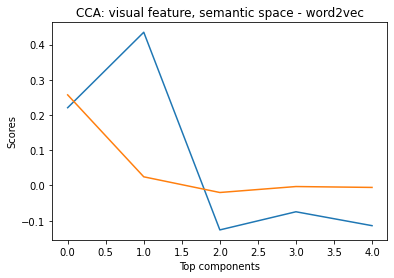

In [23]:
cca3 = CCA(n_components=5)
cca3.fit(features_w2v, w2v)
kf = KFold(n_splits = 7)
for train_index, test_index in kf.split(features_w2v):
    X_r = []
    Y_r = []
    features_train = features_w2v[train_index,]
    dims_train = w2v[train_index,]
    features_test = features_w2v[test_index,]
    dims_test = w2v[test_index,]
    
    X_train_r, Y_train_r = cca3.transform(features_train, dims_train)
    X_test_r, Y_test_r = cca3.transform(features_test, dims_test)

    X_r.append(X_test_r)    
    Y_r.append(Y_test_r)    
    
X_r = np.array(X_r)
Y_r = np.array(Y_r)
X_r = np.reshape(X_r, (X_r.shape[1], X_r.shape[2]))
Y_r = np.reshape(Y_r, (Y_r.shape[1], Y_r.shape[2]))
print(X_r.shape)

mean_X_r = np.nanmean(X_r, axis=0) # mean across k folds 
mean_Y_r = np.nanmean(Y_r, axis=0) # mean across k folds 

print(mean_X_r)
print(mean_Y_r)

plt.title('CCA: visual feature, semantic space - word2vec')

plt.plot(mean_X_r)
plt.plot(mean_Y_r)
plt.xlabel('Top components')
plt.ylabel('Scores')


(44, 5)
[-2.89091576e-08  2.42310431e-09 -4.00671898e-08 -2.20680723e-08
 -1.64535538e-08]
[-0.07128205  0.00351706 -0.06444782 -0.02632941 -0.03705929]


Text(0, 0.5, 'Scores')

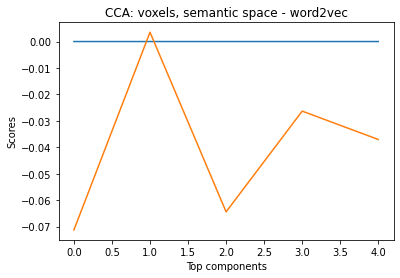

In [24]:
cca4 = CCA(n_components=5)
cca4.fit(voxels_w2v, w2v)
kf = KFold(n_splits = 7)
for train_index, test_index in kf.split(voxels_w2v):
    X_r = []
    Y_r = []
    features_train = voxels_w2v[train_index,]
    dims_train = w2v[train_index,]
    features_test = voxels_w2v[test_index,]
    dims_test = w2v[test_index,]
    
    X_train_r, Y_train_r = cca4.transform(features_train, dims_train)
    X_test_r, Y_test_r = cca4.transform(features_test, dims_test)

    X_r.append(X_test_r)    
    Y_r.append(Y_test_r)    
    
X_r = np.array(X_r)
Y_r = np.array(Y_r)
X_r = np.reshape(X_r, (X_r.shape[1], X_r.shape[2]))
Y_r = np.reshape(Y_r, (Y_r.shape[1], Y_r.shape[2]))
print(X_r.shape)

mean_X_r = np.nanmean(X_r, axis=0) # mean across k folds 
mean_Y_r = np.nanmean(Y_r, axis=0) # mean across k folds 

print(mean_X_r)
print(mean_Y_r)

plt.title('CCA: voxels, semantic space - word2vec')

plt.plot(mean_X_r)
plt.plot(mean_Y_r)
plt.xlabel('Top components')
plt.ylabel('Scores')
